# Abstract ordening neural netowrk testing
This neural networks's job is to order and differentiate an abstract, recognizing objective, methods, results, conclusions from a single abstract.
Using CNNs, vectorizing and embedding of the strings


## Helper functions
- convert txt to list of dictionaries
- calculate performance of model
- fitting model function
- splitting a sentence into chars



In [1]:
def from_text_to_dict(text_dir):
  """
  Imports from the directory, separates and turns into
  list of dictionaries as seen here
  -> list of dicts = [{"line num": 0,
    "text": "fdksldkfm",
    "target": "BACKGROUND",
    "lines_per_paper": 11}
    ...]
  """
  with open(text_dir) as t:
    # get list of each line
    lines = t.readlines()
    
    # get each abstract in a list, convert to a list of lists
    counter = 0
    abstracts = []
    abstract = []
    for line in lines:
      # line with len == 1 is abstract separator
      if len(line) == 1:
        abstracts.append(abstract)
        abstract = []
      else:
        # do not append abstract number
        if line[0] != "#":
          abstract.append(line)
    
    # dictionary to return
    list_of_dicts = []

    for a in abstracts:
      total_lines = len(a)
      # get all the sentences
      for i, sentence in enumerate(a):
        # separate label from sentence
        separated = "".join(sentence).split("\t")
        # get info in dictionary
        helper = {
            "line_num": i,
            "sentence": separated[1],
            "target": separated[0],
            "lines_per_abstract": total_lines - 1
        }
        # append to list
        list_of_dicts.append(helper)

    return list_of_dicts


In [2]:
def calculate_result(prediction, labels):
  """
  Calculates f1-score, accuracy, precision and recall.
  Returns dictionary with said information.
  """
  from sklearn.metrics import accuracy_score, precision_recall_fscore_support
  
  # Calculate model accuracy
  model_accuracy = accuracy_score(prediction, labels) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(prediction, labels, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

  return result_dict

In [3]:
def fit_model(model):
  """
  Fits the model and returns the history of the 
  fitting.
  """

  history = model.fit(train_dataset, epochs=5, steps_per_epoch=int(0.2*len(train_dataset)),
                     validation_data=validation_dataset, validation_steps=int(0.2*len(validation_dataset)))
  
  return history

In [4]:
def split_characters(sentence):
  """ 
  Returns the a string of space-separated characters 
  of the original sentnce.
  """

  return " ".join(list(sentence))

## Data Preprocessing

In [5]:
# get the data (Google Colab way)
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [6]:
# import data from folder to instance
import pandas as pd
train_data = from_text_to_dict("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt")
test_data = from_text_to_dict("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt")
validation_data = from_text_to_dict("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt")

# convert to dataframes
train_data_dataframe = pd.DataFrame(train_data)
test_data_dataframe = pd.DataFrame(test_data)
validation_data_dataframe = pd.DataFrame(validation_data)

# observe result
# train_data_dataframe.head(12)

In [34]:
train_data[0]

{'line_num': 0,
 'lines_per_abstract': 11,
 'sentence': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'target': 'OBJECTIVE'}

In [7]:
# get lists of all sentences 
train_sentences = train_data_dataframe["sentence"].tolist()
test_sentences = test_data_dataframe["sentence"].tolist()
validation_sentences = validation_data_dataframe["sentence"].tolist()

In [8]:
# one hot encode labels 
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_ohe = one_hot_encoder.fit_transform(train_data_dataframe["target"].to_numpy().reshape(-1, 1)) # first one is fitted to data
test_labels_ohe = one_hot_encoder.transform(test_data_dataframe["target"].to_numpy().reshape(-1, 1)) 
validation_labels_ohe = one_hot_encoder.transform(validation_data_dataframe["target"].to_numpy().reshape(-1, 1))

# observe results
# train_labels_ohe

In [9]:
# label encode labels, encode to integers [0, ... , number_of_classes]
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_data_dataframe["target"].to_numpy()) # first one is fitted to data
test_labels_encoded = label_encoder.fit_transform(test_data_dataframe["target"].to_numpy())
validation_labels_encoded = label_encoder.fit_transform(validation_data_dataframe["target"].to_numpy())

# observe results
# train_labels_encoded

In [10]:
# get name and ammount of labels
num_labels = len(label_encoder.classes_)
labels = label_encoder.classes_

In [11]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

assertion -> 55


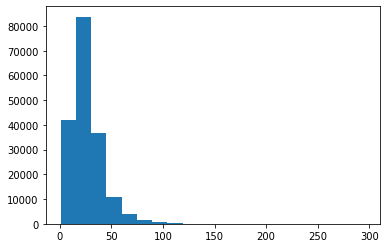

In [12]:
# define embedding information
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# find average of sentence length in training sentences
sentence_lengths = [len(sentence.split()) for sentence in train_sentences]
avg_sentence_length = np.round(np.average(sentence_lengths))
# avg_sentence_length 
# average is 26 -- 

# observe sentences lengths' distribution
plt.hist(sentence_lengths, bins=20);
# ~95% are from 0 - ~60
# assert observation
most_s_lens = int(np.percentile(sentence_lengths, 95))
print(f"assertion -> {most_s_lens}")
# 95% are 55

In [13]:
# create tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_ohe))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_ohe))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_sentences, validation_labels_ohe))

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [14]:
# split sequence-level data split into character-level data splits
train_chars = [split_characters(sentence) for sentence in train_sentences]
validation_chars = [split_characters(sentence) for sentence in validation_sentences]
test_chars = [split_characters(sentence) for sentence in test_sentences]

assertion -> 581.0


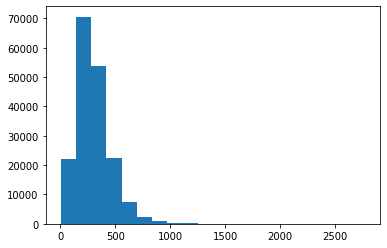

In [15]:
# define char embedding information
# find average length of sentences
chars_lens = [len(split_characters(sentence)) for sentence in train_sentences]
avg_chars_sentence = np.round(np.average(chars_lens))
# avg_chars_sentence
# average is 300 chars/sentence

# observe chars distribution in training sentences
plt.hist(chars_lens, bins=20);
# 95% are from 0 - ~510

# assert observation
most_c_lens = np.percentile(chars_lens, 95)
print(f"assertion -> {most_c_lens}")
# 95% are 581

In [16]:
# get all keyboard chars, ammount
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alpha_len = len(alphabet)

In [17]:
# create hybrid datasets
train_data_char_sentence = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # data has to be in the SAME order as constructed
train_labels_char_sentence = tf.data.Dataset.from_tensor_slices((train_labels_ohe))
train_dataset_hybrid = tf.data.Dataset.zip((train_data_char_sentence, train_labels_char_sentence)) # combine into single training dataset

validation_data_char_sentence = tf.data.Dataset.from_tensor_slices((validation_sentences, validation_chars)) # data has to be in the SAME order as constructed
validation_labels_char_sentence = tf.data.Dataset.from_tensor_slices((validation_labels_ohe))
validation_dataset_hybrid = tf.data.Dataset.zip((validation_data_char_sentence, validation_labels_char_sentence)) # combine into single training dataset

train_data_char_sentence = train_data_char_sentence.batch(32).prefetch(tf.data.AUTOTUNE)
train_labels_char_sentence = train_labels_char_sentence.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset_hybrid = train_dataset_hybrid.batch(32).prefetch(tf.data.AUTOTUNE)
validation_data_char_sentence = validation_data_char_sentence.batch(32).prefetch(tf.data.AUTOTUNE)
validation_labels_char_sentence = validation_labels_char_sentence.batch(32).prefetch(tf.data.AUTOTUNE)
validation_dataset_hybrid = validation_dataset_hybrid.batch(32).prefetch(tf.data.AUTOTUNE)

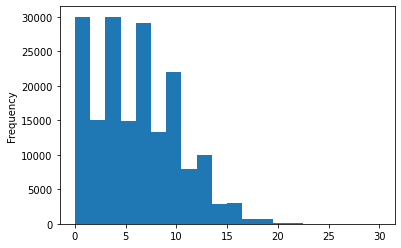

In [18]:
# index one-hot-encoding 
# get the best number of lines in abstracts
train_data_dataframe.line_num.plot.hist(bins=20)
# 18 gets around 90%

train_index_ohe = tf.one_hot(train_data_dataframe["line_num"].to_numpy(), depth=18)
validation_index_ohe = tf.one_hot(validation_data_dataframe["line_num"].to_numpy(), depth=18)
test_index_ohe = tf.one_hot(test_data_dataframe["line_num"].to_numpy(), depth=18)

# use the same number for total lines in abstract
train_total_ohe = tf.one_hot(train_data_dataframe["lines_per_abstract"].to_numpy(), depth=18)
validation_total_ohe = tf.one_hot(validation_data_dataframe["lines_per_abstract"].to_numpy(), depth=18)
test_total_ohe = tf.one_hot(test_data_dataframe["lines_per_abstract"].to_numpy(), depth=18)

In [19]:
# create tri-hybrid datasets
train_sentence_idx_tot = tf.data.Dataset.from_tensor_slices((train_index_ohe, train_total_ohe, train_sentences))
train_sentence_idx_tot_labels = tf.data.Dataset.from_tensor_slices(train_labels_ohe)
train_tribrid_dataset = tf.data.Dataset.zip((train_sentence_idx_tot, train_sentence_idx_tot_labels))
train_tribrid_dataset = train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_sentence_idx_tot_val = tf.data.Dataset.from_tensor_slices((validation_index_ohe, validation_total_ohe, validation_sentences))
train_sentence_idx_tot_labels_val = tf.data.Dataset.from_tensor_slices(validation_labels_ohe)
validation_tribrid_dataset = tf.data.Dataset.zip((train_sentence_idx_tot, train_sentence_idx_tot_labels))
validation_tribrid_dataset = validation_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Useful Keras Layers
- Word vectorization layer
- Embedding layer
- Character vectorization layer

In [20]:
# vectorization layer 
# ammount of tokens (https://arxiv.org/pdf/1710.06071.pdf page 3)
max_tokens = 68000
# create vectorization layer
text_vectorization_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=max_tokens, # vocabulary length of train data
                                                                                        output_sequence_length=most_s_lens) # accomodate for 95%

# adapt to dataset
text_vectorization_layer.adapt(train_sentences)

# test on random sentence and observe shape
sample = "this is a test made for this experiment"
print(text_vectorization_layer([sample]))


tf.Tensor(
[[  23   20    8  128 1050   11   23 2552    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 55), dtype=int64)


In [21]:
# embedding layer
# get vocabulary
data_vocabulary = text_vectorization_layer.get_vocabulary()
token_embedding_layer = layers.Embedding(input_dim=len(data_vocabulary), output_dim=128,
                                                       mask_zero=True, name="token_embedding_layer")
# observe result
print(token_embedding_layer(text_vectorization_layer([sample])))
# shape must be 1 sentence, 55 tokens, 128 embedding-per-token

tf.Tensor(
[[[ 0.04322379  0.01551266 -0.00571982 ...  0.00481644  0.04445176
   -0.00235121]
  [ 0.02555771  0.02199808 -0.04634216 ...  0.00566559  0.00549475
    0.03073646]
  [-0.01232402  0.00915813 -0.02863557 ...  0.02851471 -0.00616484
   -0.03210302]
  ...
  [-0.01429086  0.03403969  0.01062155 ...  0.03385184 -0.04312538
   -0.04870063]
  [-0.01429086  0.03403969  0.01062155 ...  0.03385184 -0.04312538
   -0.04870063]
  [-0.01429086  0.03403969  0.01062155 ...  0.03385184 -0.04312538
   -0.04870063]]], shape=(1, 55, 128), dtype=float32)


In [22]:
# character vectorization layer
max_char_tokens = alpha_len + 2 # add space and OOV
character_vectorization_layer = tf.keras.layers.TextVectorization(max_tokens=max_char_tokens, # chars lens in alphabet
                                                         output_sequence_length=int(most_c_lens), # accomodate for 95%
                                                         standardize="lower_and_strip_punctuation") 

# adapt to dataset
character_vectorization_layer.adapt(train_chars)

# test on random sentence and observe shape
sample_c = "A f t e r   @ m o n t h s"
print(character_vectorization_layer([sample_c]))

tf.Tensor(
[[ 5 17  3  2  8 15  7  6  3 13  9  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  

In [23]:
# character embedding layer
# get character vocabulary
char_vocab = character_vectorization_layer.get_vocabulary()
character_embedding_layer = tf.keras.layers.Embedding(input_dim=len(char_vocab),
                                                      output_dim=20, # paper fig 1
                                                      mask_zero=True)

# observe result
print(character_embedding_layer(character_vectorization_layer([sample_c])))
# shape must be 1 sentence, 581 tokens, 20 embedding-per-token

tf.Tensor(
[[[ 0.02178346 -0.031915    0.02053697 ... -0.00524558 -0.04439155
    0.04902664]
  [-0.00751108 -0.00986353 -0.02377131 ...  0.02044674 -0.04896079
   -0.01680754]
  [ 0.03930097 -0.01544137 -0.01673397 ... -0.00311076 -0.00621986
   -0.00271805]
  ...
  [ 0.01493483  0.01522154  0.0468394  ...  0.01623854  0.01721411
   -0.0323495 ]
  [ 0.01493483  0.01522154  0.0468394  ...  0.01623854  0.01721411
   -0.0323495 ]
  [ 0.01493483  0.01522154  0.0468394  ...  0.01623854  0.01721411
   -0.0323495 ]]], shape=(1, 581, 20), dtype=float32)


In [24]:
train_data_dataframe.head(3)

,line_num,sentence,target,lines_per_abstract
0,0,To investigate the efficacy of @ weeks of dail...,OBJECTIVE,11
1,1,A total of @ patients with primary knee OA wer...,METHODS,11
2,2,Outcome measures included pain reduction and i...,METHODS,11


## Models
- model_0 -> tfidf model
- model_1 -> recurrent neural network
- model_2 -> LSTM model
- model_3 -> bi-hybrid model (sentences and characters)
- model_4 -> tri-hybrid model (sentences and line index)


In [25]:
# model_0 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create model 0 as sklearn pipeline
model_0 = Pipeline([
  ("tf_idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# fit the pipeline
model_0.fit(X=train_sentences, y=train_labels_encoded)

# evaluate pipeline
model_0.score(X=validation_sentences, y=validation_labels_encoded)

# predict with model
pred_0 = model_0.predict(validation_sentences)

# observe performance
calculate_result(pred_0, validation_labels_encoded)

{'accuracy': 72.1832384482987,
 'f1': 0.7447397336209445,
 'precision': 0.7835634520695112,
 'recall': 0.7218323844829869}

In [26]:
# create model 1 as rnn
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
# vectorizing and embedding layers
o = text_vectorization_layer(inputs)
o = token_embedding_layer(o)
# rnn structure
o = layers.GRU(128)(o)
# output layer
outputs = layers.Dense(num_labels, activation="softmax")(o)

# create model
model_1 = tf.keras.Model(inputs, outputs)

# compile the model
model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
hist_1 = model_1.fit(train_dataset, epochs=5, steps_per_epoch=int(0.2*len(train_dataset)),
                     validation_data=validation_dataset, validation_steps=int(0.2*len(validation_dataset)))

Epoch 1/5
1125/1125 [==============================] - 49s 35ms/step - loss: 0.7419 - accuracy: 0.7043 - val_loss: 0.5913 - val_accuracy: 0.7659
Epoch 2/5
1125/1125 [==============================] - 36s 32ms/step - loss: 0.5628 - accuracy: 0.7900 - val_loss: 0.5171 - val_accuracy: 0.8006
Epoch 3/5
1125/1125 [==============================] - 35s 31ms/step - loss: 0.5414 - accuracy: 0.7971 - val_loss: 0.4793 - val_accuracy: 0.8153
Epoch 4/5
1125/1125 [==============================] - 37s 33ms/step - loss: 0.5000 - accuracy: 0.8153 - val_loss: 0.4753 - val_accuracy: 0.8188
Epoch 5/5
1125/1125 [==============================] - 37s 33ms/step - loss: 0.4911 - accuracy: 0.8167 - val_loss: 0.4801 - val_accuracy: 0.8214


In [27]:
# predict with model 1
pred_1 = model_1.predict(validation_sentences)
pred_1 = tf.argmax(pred_1, axis=1)
# observe model 1's performance
calculate_result(pred_1, validation_labels_encoded)

{'accuracy': 82.01045942009797,
 'f1': 0.822601777290057,
 'precision': 0.830043764482926,
 'recall': 0.8201045942009797}

In [28]:
# create model_2 as LSTM
inputs = layers.Input(shape=(1,), dtype=tf.string)
# vectorizing and embedding layers
o = text_vectorization_layer(inputs)
o = token_embedding_layer(o)
# LSTM structure
o = layers.LSTM(128)(o)
# output layers
outputs = layers.Dense(num_labels, activation="softmax")(o)

# create model
model_2 = tf.keras.Model(inputs, outputs)

# compile the model
model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.categorical_crossentropy,
                metrics=["accuracy"])

# fit the model
hist_2 = fit_model(model_2)

Epoch 1/5
1125/1125 [==============================] - 46s 36ms/step - loss: 0.5489 - accuracy: 0.7992 - val_loss: 0.5557 - val_accuracy: 0.7940
Epoch 2/5
1125/1125 [==============================] - 45s 40ms/step - loss: 0.4548 - accuracy: 0.8379 - val_loss: 0.5065 - val_accuracy: 0.8151
Epoch 3/5
1125/1125 [==============================] - 39s 34ms/step - loss: 0.4346 - accuracy: 0.8444 - val_loss: 0.4937 - val_accuracy: 0.8146
Epoch 4/5
1125/1125 [==============================] - 38s 34ms/step - loss: 0.4008 - accuracy: 0.8581 - val_loss: 0.5039 - val_accuracy: 0.8153
Epoch 5/5
1125/1125 [==============================] - 38s 34ms/step - loss: 0.3956 - accuracy: 0.8583 - val_loss: 0.5148 - val_accuracy: 0.8188


In [29]:
# predict the model
pred_2 = model_2.predict(validation_sentences)
pred_2 = tf.argmax(pred_2, axis=1)

# observe model's performance
calculate_result(pred_2, validation_labels_encoded)

{'accuracy': 81.55368727657884,
 'f1': 0.8180663131658061,
 'precision': 0.8243390851153358,
 'recall': 0.8155368727657885}

In [30]:
# create model 3 as hybrid character / sentence embeddings
# setup sentence/token model
sentence_inputs = layers.Input(shape=[], dtype=tf.string, name="sentence_input") 
sentence_token = text_vectorization_layer(sentence_inputs)
sentence_embedding = token_embedding_layer(sentence_token)
sentence_gru = layers.GRU(128)(sentence_embedding)
sentence_outputs = layers.Dense(num_labels, activation="tanh", name="sentence_output")(sentence_gru)
sentence_model = tf.keras.Model(sentence_inputs, sentence_outputs)

# setup character model
character_inputs = layers.Input(shape=(1,), dtype=tf.string, name="character_input")
character_token = character_vectorization_layer(character_inputs)
character_embedding = character_embedding_layer(character_token)
character_gru = layers.GRU(128)(character_embedding)
character_outputs = layers.Dense(num_labels, activation="tanh", name="character_output")(character_gru)
character_model = tf.keras.Model(character_inputs, character_outputs)

# concatenate outputs
sentence_char_concat = layers.Concatenate(name="sentence_char_concat")([sentence_model.output, character_model.output]) # has to be with model.outputs

# create output layers and add dropouts for overfitting
combined_dropout = layers.Dropout(0.5)(sentence_char_concat)
combined_dense = layers.Dense(64, activation="tanh")(combined_dropout)
combined_dropout = layers.Dropout(0.5)(combined_dense)
output_layer_combined = layers.Dense(num_labels, activation="softmax")(combined_dropout)

# construct hybrid model
model_4 = tf.keras.Model(inputs=[sentence_model.input, character_model.input], outputs=output_layer_combined)

# compile the model
model_4.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.categorical_crossentropy,
                metrics=["accuracy"])

# fit the model
hist_4 = model_4.fit(train_dataset_hybrid, epochs=5, steps_per_epoch=int(0.2*len(train_dataset_hybrid)),
                     validation_data=validation_dataset_hybrid, validation_steps=int(0.2*len(validation_dataset_hybrid)))


Epoch 1/5
1125/1125 [==============================] - 139s 115ms/step - loss: 0.8382 - accuracy: 0.6677 - val_loss: 0.5730 - val_accuracy: 0.7725
Epoch 2/5
1125/1125 [==============================] - 128s 114ms/step - loss: 0.6758 - accuracy: 0.7304 - val_loss: 0.5385 - val_accuracy: 0.7994
Epoch 3/5
1125/1125 [==============================] - 117s 104ms/step - loss: 0.6367 - accuracy: 0.7462 - val_loss: 0.5381 - val_accuracy: 0.8067
Epoch 4/5
1125/1125 [==============================] - 131s 116ms/step - loss: 0.5976 - accuracy: 0.7606 - val_loss: 0.5483 - val_accuracy: 0.8099
Epoch 5/5
1125/1125 [==============================] - 129s 114ms/step - loss: 0.5811 - accuracy: 0.7716 - val_loss: 0.5781 - val_accuracy: 0.8052


In [31]:
# predict the model
pred_4 = model_4.predict(validation_dataset_hybrid)
pred_4 = tf.argmax(pred_4, axis=1)

# observe model's performance
calculate_result(pred_4, validation_labels_encoded)

{'accuracy': 80.21978021978022,
 'f1': 0.8058392533750133,
 'precision': 0.8159697421599741,
 'recall': 0.8021978021978022}

In [32]:
# create model 5 as hybrid sentence / index
# setup sentence/token model
sentence_inputs = layers.Input(shape=[], dtype=tf.string, name="sentence_input") 
sentence_token = text_vectorization_layer(sentence_inputs)
sentence_embedding = token_embedding_layer(sentence_token)
sentence_gru = layers.GRU(128)(sentence_embedding)
sentence_outputs = layers.Dense(num_labels, activation="tanh", name="sentence_output")(sentence_gru)
sentence_model = tf.keras.Model(sentence_inputs, sentence_outputs)

# setup index model
index_inputs = layers.Input(shape=(18,), dtype=tf.int64, name="index_input")
index_hidden = layers.Dense(32, activation="tanh")(index_inputs)
index_outputs = layers.Dense(32, activation="softmax", name="index_output")(index_hidden)
index_model = tf.keras.Model(index_inputs, index_outputs)

# setup total model
total_inputs = layers.Input(shape=(18,), dtype=tf.int64, name="total_input")
total_hidden = layers.Dense(32, activation="tanh")(total_inputs)
total_outputs = layers.Dense(32, activation="softmax", name="total_output")(total_hidden)
total_model = tf.keras.Model(total_inputs, total_outputs)

# combine total and index 
index_total_concat = layers.Concatenate(name="index_total_concat")([index_model.output, total_model.output])

# dropout to prevent overfitting
d = layers.Dense(128, activation="tanh")(index_total_concat)
d = layers.Dropout(0.5)(d)

# combine sentence and concated lines
hybrid_layer = layers.Concatenate(name="index_total_sentence_concat")([d, sentence_model.output])

# create last hybrid output
hybrid_output = layers.Dense(num_labels, activation="softmax", name="index_total_sentence_output")(hybrid_layer)

# create model 5
model_5 = tf.keras.Model(inputs=[index_model.input, total_model.input, sentence_model.input], outputs=hybrid_output, name="index_total_sentence_model")

# compile model 
model_5.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

# fit the model
hist_5 = model_5.fit(train_tribrid_dataset, epochs=5, steps_per_epoch=int(0.2*len(train_tribrid_dataset)),
                     validation_data=validation_tribrid_dataset, validation_steps=int(0.2*len(validation_tribrid_dataset)))

Epoch 1/5
1125/1125 [==============================] - 49s 39ms/step - loss: 0.5584 - accuracy: 0.8038 - val_loss: 0.3486 - val_accuracy: 0.8752
Epoch 2/5
1125/1125 [==============================] - 56s 50ms/step - loss: 0.3311 - accuracy: 0.8767 - val_loss: 0.3265 - val_accuracy: 0.8813
Epoch 3/5
1125/1125 [==============================] - 44s 39ms/step - loss: 0.2898 - accuracy: 0.8982 - val_loss: 0.3180 - val_accuracy: 0.8849
Epoch 4/5
1125/1125 [==============================] - 45s 40ms/step - loss: 0.2452 - accuracy: 0.9186 - val_loss: 0.3196 - val_accuracy: 0.8835
Epoch 5/5
1125/1125 [==============================] - 44s 39ms/step - loss: 0.2297 - accuracy: 0.9224 - val_loss: 0.3466 - val_accuracy: 0.8734


In [33]:
# add learning rate lowering callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=1, verbose=1, mode="min")
# add early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=0, mode="min")
# redo the model and add callback
# setup sentence/token model
sentence_inputs = layers.Input(shape=[], dtype=tf.string, name="sentence_input") 
sentence_token = text_vectorization_layer(sentence_inputs)
sentence_embedding = token_embedding_layer(sentence_token)
sentence_gru = layers.GRU(128)(sentence_embedding)
sentence_outputs = layers.Dense(num_labels, activation="tanh", name="sentence_output")(sentence_gru)
sentence_model = tf.keras.Model(sentence_inputs, sentence_outputs)

# setup index model
index_inputs = layers.Input(shape=(18,), dtype=tf.int64, name="index_input")
index_hidden = layers.Dense(32, activation="tanh")(index_inputs)
index_outputs = layers.Dense(32, activation="softmax", name="index_output")(index_hidden)
index_model = tf.keras.Model(index_inputs, index_outputs)

# setup total model
total_inputs = layers.Input(shape=(18,), dtype=tf.int64, name="total_input")
total_hidden = layers.Dense(32, activation="tanh")(total_inputs)
total_outputs = layers.Dense(32, activation="softmax", name="total_output")(total_hidden)
total_model = tf.keras.Model(total_inputs, total_outputs)

# combine total and index 
index_total_concat = layers.Concatenate(name="index_total_concat")([index_model.output, total_model.output])

# dropout to prevent overfitting
d = layers.Dense(128, activation="tanh")(index_total_concat)
d = layers.Dropout(0.5)(d)

# combine sentence and concated lines
hybrid_layer = layers.Concatenate(name="index_total_sentence_concat")([d, sentence_model.output])

# create last hybrid output
hybrid_output = layers.Dense(num_labels, activation="softmax", name="index_total_sentence_output")(hybrid_layer)

# create model 5
model_6 = tf.keras.Model(inputs=[index_model.input, total_model.input, sentence_model.input], outputs=hybrid_output, name="index_total_sentence_model")

# compile model 
model_6.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

# fit the model
hist_5 = model_6.fit(train_tribrid_dataset, epochs=25, steps_per_epoch=int(0.2*len(train_tribrid_dataset)),
                     validation_data=validation_tribrid_dataset, validation_steps=int(0.2*len(validation_tribrid_dataset)),
                     callbacks=[reduce_lr, early_stop])

Epoch 1/25
1125/1125 [==============================] - 49s 40ms/step - loss: 0.5388 - accuracy: 0.8141 - val_loss: 0.3522 - val_accuracy: 0.8584 - lr: 0.0010
Epoch 2/25
1125/1125 [==============================] - 45s 40ms/step - loss: 0.2999 - accuracy: 0.8896 - val_loss: 0.3259 - val_accuracy: 0.8851 - lr: 0.0010


In [44]:
r = model_1.predict(["Participants ' perceptions of their quality of life and level of coercion were about the same."])
r 
r


array([[2.8406357e-04, 7.3077995e-03, 1.2037772e-01, 1.2795276e-04,
        8.7190253e-01]], dtype=float32)